Starting with a 2-D wave equation that describes a wave in a stratified medium defined by the Brunt-Vaisalla Frequency $N=\sqrt{\frac{-g}{\rho_o}\frac{\partial \rho}{ \partial z}}$. 

$$\frac{\partial}{\partial t^2}(\nabla^2 w) + N^2(z) \nabla_h^2 w = 0$$

Seperating variables and assuming a horiztonal and temporal symetery. The solution should look be the following.
$$ w(x,z,t) = \hat{w}(z)exp[i(kx-\omega t)]$$

Plugging in this equation into the 2-D wave equation we will arrive at the helmholtz equation and be able to solve for the vertical modes of the wave.

$$ \frac{\partial^2 \hat{w} }{\partial z^2 } - N^2 k^2 \hat{w} = 0 $$

With boundary conditions

$$ \hat{w}(z=0) = 0 \quad \quad \hat{w}(z=H) = 0 $$

The stratification profile will be modeled using the 'Munk Depth Profile for Sound'
$$c(z) = 1 + \epsilon(\bar{z} - 1 + exp(-\bar{z}))$$ 
I will use the nominal value of the internal wave frequency as episilon so that N is near omega but not less than omega.  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp 
from scipy.interpolate import interp1d

#Consts
D     = 5e3                    #Depth of the ocean
R     = 1e4                    #Depth of the ocean
cbar  = 1500                   #Average sound speed
epi   = 0.01                   #Pertubation Scale
AP    = 1000                   #Number of grid axis points
N_o   = 6*(2*np.pi/3600)       #6 cph
omega = 2*N_o/3                #2/3 cph

#Average depth described by munk profile
def zbar (z):
    return 2*(z-1000)/1000

#Munk sound depth profile
def c ( z ):
    return cbar*(1 + epi*(zbar(z)-1+np.exp(-zbar(z))))

#Expotential N profile
def N ( z ):
    return  N_o*(1+np.exp(-zbar(z)))

def K(m):
    return  (omega/N_o)/np.sqrt(1-omega**2/N_o**2) * (m*np.pi/D)

The equation is then numerically solved using a BVP solver. Using the two boundary conditions and two coupled odes it computes the solutions with initial guesses for the eigenvalues  $n \pi$.

In [3]:


#PDE weight function
def r(z):
    return (N(z)**2 - omega**2)/(omega**2)

# Set of couple ode's decomposed from the PDE
#  dw/dz  = w' 
#  dw'/dz = -k^2 * r(z) * w
def odes ( z, w , p):
    k = p[0]
    return np.vstack((w[1], -(k**2)*r(z)*w[0]))


#Boundary conditions for the top and bottom bounds
def bc(wa,wb,p):
    k = p[0]
    
    return np.array([wa[0],wb[0],wa[1]-k])

z = np.linspace(0,D,100)

# First mode, w(z=0,z=1)=0, init guess w(z=d/2)=1
w = np.zeros((2,z.size))
w[0,round(z.size/2)] = 1
sol1 = solve_bvp(odes,bc,z,w,p=[np.pi/R])

# Second mode, w(z=0,z=1)=0, init guess w(z=d/4)=1
w = np.zeros((2,z.size))
w[0,round(z.size/4)] = 1
sol2 = solve_bvp(odes,bc,z,w,p=[2*np.pi/R])

# Third mode, w(z=0,z=1)=0, init guess w(z=d/6)=1
w = np.zeros((2,z.size))
w[0,round(z.size/5)] = -1 
sol3 = solve_bvp(odes,bc,z,w,p=[3*np.pi/R])

# Four mode, w(z=0,z=1)=0, init guess w(z=d/3)=-1
w = np.zeros((2,z.size))
w[0,round(z.size/4)] = 1
sol4 = solve_bvp(odes,bc,z,w,p=[4*np.pi/R])


In [4]:
#BVP calculated values of K in units of pi
kn = [(R*x)/np.pi for x in [ sol1.p[0],sol2.p[0],sol3.p[0],sol4.p[0] ] ] 
print(kn)
kn = [x for x in [ sol1.p[0],sol2.p[0],sol3.p[0],sol4.p[0] ] ] 

[0.8959146917320162, 1.7536140339226132, 2.5513145534579573, 3.46615189818213]


<IPython.core.display.Javascript object>


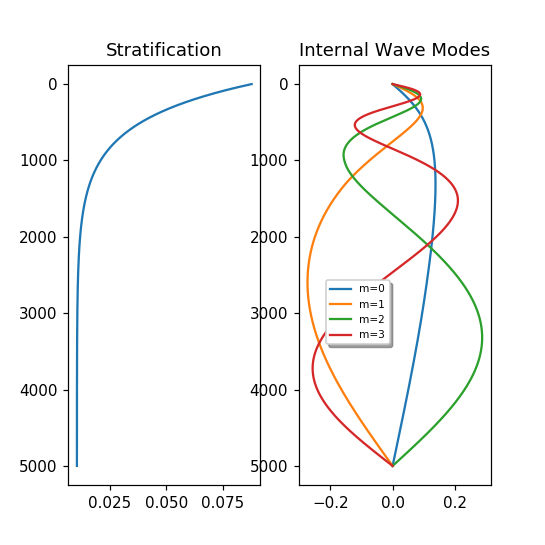

In [12]:
%matplotlib notebook
#Plotting Stratification and Internal Wave Modes
wave_vector = []
eigen_wave  = []

#Scale solution to grid
z_axis = np.linspace(0,D,AP)
for s in [sol1,sol2,sol3,sol4]:
    wave_vector.append(s.sol(z_axis)[0])
    eigen_wave.append(interp1d(z_axis,s.sol(z_axis)[0])) 

n_axis = N(z_axis)

fig, ax = plt.subplots(1,2)

#Stratification
ax[0].set_title('Stratification')
ax[0].plot(n_axis,z_axis)
ax[0].invert_yaxis()

#Modes
ax[1].set_title('Internal Wave Modes')
wave_vector = wave_vector[0:4]
for i,wv in enumerate(wave_vector):
   ax[1].plot(wv,z_axis,label=("m=%i" % i))
    
ax[1].invert_yaxis()
legend = ax[1].legend(loc='upper right', bbox_to_anchor=(0.5, 0.5),
                      shadow=True, fontsize='x-small')
fig.set_size_inches(5,5)
plt.show()
plt.savefig('figs/iw_vmodes_ideal.png')

Now that we are able to generate the modes of the internal wave we combine them in a sum to recreate the wavefield. 

In [8]:
#TODO Calculate Real Coefficients
co = [0.4,0.3,0.2,0.1]

def r_wave(n,x):
    k = kn[n]
    return np.cos(k*x)

def z_wave(m,z):
    # Get interpolated function at index m and point z
    egfn = eigen_wave[m]
    return egfn(z)

def wavefield(x,z,co):
    wf = 0
    for i,c in enumerate(co):
        wf += c*z_wave(i,z)*r_wave(i,x)
    return wf

def displacement_scale(z):
    return (1/omega)*(omega**2/(N_o**2-omega**2))**(.25)

def c_2d(x,z):
    return c(z)

def dc(x,z):
    return cbar*(10*epi*(1-np.exp(-zbar(z)))) 

#Make a 2D grid to project wavefield on
x = np.linspace(0,4*R,AP)
z = np.linspace(0,D,AP)
X,Z = np.meshgrid(x,z)
WFG  = wavefield(X,Z,co)
DCFG = dc(X,Z) 
CFG  = c_2d(X,Z)

#Add wavefield to background sound profile
WFG = CFG + DCFG*WFG



The contour plot shows the sound speed profile with internal wave perturbing the field. The profile is calculated as $$\tilde{c(z)} = c(z) + \frac{\partial c}{\partial z}*\zeta(x,z)$$

<IPython.core.display.Javascript object>


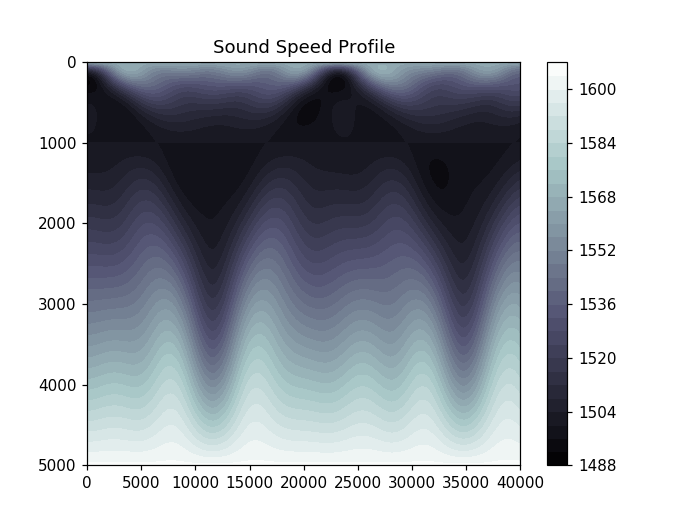

In [13]:
%matplotlib notebook
from ipywidgets import *

plt.contourf(X,Z,WFG,30,cmap=plt.cm.bone)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('Sound Speed Profile')
plt.show()
plt.savefig('figs/c_profile_iw.png')
